### CDS NYU
### DS-GA 3001 | Reinforcement Learning
### Lab 03
### February 13, 2025


# Value Iteration and Policy Iteration algorithms

<br>

---

## Section Leader


Akshitha Kumbam – ak11071@nyu.edu

Kushagra Khatwani – kk5395@nyu.edu


## Goal of Today's Lab 

In this Lab, we will implement RL algorithms which learn value functions and derive an optimal policy from the learned values, assuming a model of the environment is available. Next week we will extend these algroithms to cases where a model of the environment is not available.

In the first case study, we will build the entire agent-environment interface from scratch. This will be mostly theoretical. In the second case study, we will return to Gym, invoking an environment very similar to the one in the first case study, so you can see the similarities, but also to start using the nive features of Gym such as a graphical rendering of the environment. In future labs, we will systematically use Gym so as to work with more complex environments, and so as to focus our efforts more on building RL agents than on building environments. Today we cover the most fundamental RL agent paradigm, which assumes a model of the environment is available. 


# 1. Implement a value iteration algorithm 

Consider the following learning problem. A bear (the agent) wants to get to the honey (the positive reward) while avoiding the bees around it (negative rewards). At every state (a cell in a 3 $\times$ 4 grid), the bear can take an action such as go up, down, left or right. 

The model for this use case is fully known and represented by state transition probabilities where any of the adjacent cells can be selected randomly with a probablity of 10% (parameter `NOISE` below). The bear takes actions according to its own policy except in 10% of cases where it ends up in a randomly selected adjacent cell. For example, assume the bear is in a rugged terrain such that 10% of the time it missteps and doesn’t control where it is going. This model implies that it is more “risky” to be closer to the bees because a mistep can lead to a negative reward.

<br>

<img src="./BearBeesHoney.png" width="400">

<br>

In order to find the best way to get to the honey, the bear will walk in the environment. He might walk into the bees, get stung, and learn to avoid this state. Eventually, with time, he will figure out how to behave in any given state, to get to the honey without getting stung.

But how will the bear learn this? The value iteration algorithm is one of the most common algorithm to solve this problem. Let’s get into it.

https://towardsdatascience.com/how-to-code-the-value-iteration-algorithm-for-reinforcement-learning-8fb806e117d1

### Set up an environment for the Markov Decision Process (states, rewards, actions)

In [2]:
import numpy as np

# Hyperparameters
SMALL_ENOUGH = 0.005 # Threshold used to stop learning when max difference in learned values between two iteration is small enough
GAMMA = 0.9         
NOISE = 0.10  

# Define all states
all_states=[]
for i in range(3):
    for j in range(4):
            all_states.append((i,j))

# Define rewards for all states
rewards = {}
for i in all_states:
    if i == (1,2):
        rewards[i] = -1
    elif i == (2,2):
        rewards[i] = -1
    elif i == (2,3):
        rewards[i] = 1
    else:
        rewards[i] = 0

# Dictionnary of possible actions for all but the "end" states (1,2 and 2,2 and 2,3)
actions = {
    (0,0):('D', 'R'), 
    (0,1):('D', 'R', 'L'),    
    (0,2):('D', 'L', 'R'),
    (0,3):('D', 'L'),
    (1,0):('D', 'U', 'R'),
    (1,1):('D', 'R', 'L', 'U'),
    (1,3):('D', 'L', 'U'),
    (2,0):('U', 'R'),
    (2,1):('U', 'L', 'R'),
    }

# Initialize a policy for non-final states
policy={}
for s in actions.keys():
    policy[s] = np.random.choice(actions[s])

# Initialize value function 
# Make sure to assign value of final states with the known reward, those will not be "learned"
V={}
for s in all_states:
    if s in actions.keys():
        V[s] = 0 # Cannot change this state
    if s ==(2,2):
        V[s]=-1 # Cannot change this state
    if s == (1,2):
        V[s]=-1  # Cannot change this state
    if s == (2,3):
        V[s]=1 # Cannot change this state
  

### 1.1 Simulate a value iteration algorithm to update  state values 

In [3]:
iteration = 0

while True:
    biggest_change = 0
    for s in all_states:            
        if s in policy:
            
            old_v = V[s]
            new_v = float('-inf')  # Initialize new_v with a very low value

            for a in actions[s]:
                # Determine the next state for the intended action
                if a == 'U':
                    nxt = [s[0]-1, s[1]]
                if a == 'D':
                    nxt = [s[0]+1, s[1]]
                if a == 'L':
                    nxt = [s[0], s[1]-1]
                if a == 'R':
                    nxt = [s[0], s[1]+1]
                
                # Intended action value (with (1 - NOISE) probability)
                nxt = tuple(nxt)  # Convert to tuple
                intended_value = (1 - NOISE) * V[nxt]

                # Now we calculate the value for random alternative actions
                possible_moves = [x for x in actions[s]]  # All available actions
                random_value = 0
                if possible_moves:
                    probability_per_alt = NOISE / len(possible_moves)  # Evenly distribute noise

                    for random_a in possible_moves:
                        if random_a == 'U':
                            act = [s[0]-1, s[1]]
                        if random_a == 'D':
                            act = [s[0]+1, s[1]]
                        if random_a == 'L':
                            act = [s[0], s[1]-1]
                        if random_a == 'R':
                            act = [s[0], s[1]+1]
                        
                        act = tuple(act)
                        random_value += probability_per_alt * V[act]  # Sum up contributions from all alternatives

                # Calculate the total value for the state using the Bellman equation
                # Here since rewards are deterministic, we can take the rewards out of the sumation and teh the probability of all the s,r is 1
                v = rewards[s] + GAMMA * (intended_value + random_value)

                # Update the best value for this state
                if v > new_v:
                    new_v = v
                    policy[s] = a  # Update the policy to the best action

            # Save the best value for the state
            V[s] = new_v
            biggest_change = max(biggest_change, np.abs(old_v - V[s]))

    if iteration % 5000 == 0: 
        print(f"Step {iteration}, Biggest change = {biggest_change}")

    #OPTIONAL PRINTING VALUES
    # # Print the current value function (V) after every iteration
    # print("\nCurrent Value Function (V) after iteration", iteration)
    # for i in range(3):
    #     row = ""
    #     for j in range(4):
    #         row += f"{V[(i, j)]:.2f}  "
    #     print(row)

    # Stop learning if max difference of all values between two iterations is smaller than predefined threshold     
    if biggest_change < SMALL_ENOUGH:
        print(f"State values converged in exactly {iteration} iterations.")
        break
    
    iteration += 1


Step 0, Biggest change = 0.8099595
State values converged in exactly 7 iterations.


### Visualize the Policy and Final values for Value function

In [4]:
# Display Final Policy
print("\nFinal Policy:")
for i in range(3):
    row = ""
    for j in range(4):
        if (i, j) in policy:
            row += policy[(i, j)] + "  "
        else:
            row += "X  "  # Terminal or blocked states
    print(row)

    # Print Final Value Function
print("\nFinal State Values:")
for i in range(3):
    row = ""
    for j in range(4):
        row += f"{V[(i, j)]:.2f}  "
    print(row)


Final Policy:
R  R  R  D  
U  U  X  D  
U  U  X  X  

Final State Values:
0.48  0.54  0.61  0.74  
0.43  0.44  -1.00  0.83  
0.38  0.35  -1.00  1.00  


### 1.2 Simulate a policy iteration algorithm to update  state values

In [5]:
# Hyperparameters
SMALL_ENOUGH = 0.005  # Convergence threshold
GAMMA = 0.9           # Discount factor
NOISE = 0.10          # Probability of taking a random action

# Re-initialize policy (random)
policy = {s: np.random.choice(actions[s]) for s in actions.keys()}

#Re-initialize value function
V = {s: 0 for s in all_states}
V[(1, 2)], V[(2, 2)], V[(2, 3)] = -1, -1, 1  # Fixed terminal values

# Function to get next state
def get_next_state(s, a):
    i, j = s
    if a == 'U':
        i -= 1
    elif a == 'D':
        i += 1
    elif a == 'L':
        j -= 1
    elif a == 'R':
        j += 1
    return (i, j) if (i, j) in all_states else s  # Stay in bounds

# Policy Iteration Algorithm
def policy_iteration():
    global policy, V
    iteration = 0

    while True:
        # Policy Evaluation Step
        while True:
            biggest_change = 0
            for s in all_states:
                if s in policy:  # Non-terminal states
                    old_v = V[s]
                    a = policy[s]
                    nxt = get_next_state(s, a)

                    # Stochastic noise distribution: Evenly distribute noise over alternative actions
                    possible_moves = [x for x in actions[s]]  # Alternative moves
                    random_value = 0
                    if possible_moves:
                        probability_per_alt = NOISE / len(possible_moves)  # Split noise equally

                        for random_a in possible_moves:
                            act = get_next_state(s, random_a)
                            random_value += probability_per_alt * V[act]  # Weighted sum of all alt actions
                    
                    # Update value with the intended action and alternative actions
                    V[s] = rewards[s] + GAMMA * ((1 - NOISE) * V[nxt] + random_value)
                    biggest_change = max(biggest_change, np.abs(old_v - V[s]))

            if biggest_change < SMALL_ENOUGH:  # Stop if values converged
                break

        # Policy Improvement Step
        policy_stable = True
        for s in actions.keys():
            old_action = policy[s]
            best_action = None
            best_value = float('-inf')

            # Evaluate all actions and choose the one with the highest value
            for a in actions[s]:
                nxt = get_next_state(s, a)

                # Stochastic noise distribution for policy improvement
                possible_moves = [x for x in actions[s]]
                random_value = 0
                if possible_moves:
                    probability_per_alt = NOISE / len(possible_moves)

                    for random_a in possible_moves:
                        act = get_next_state(s, random_a)
                        random_value += probability_per_alt * V[act]

                # Compute the expected value for this action
                v = rewards[s] + GAMMA * ((1 - NOISE) * V[nxt] + random_value)

                if v > best_value:
                    best_value = v
                    best_action = a

            policy[s] = best_action  # Update policy
            if old_action != best_action:
                policy_stable = False  # Policy changed

        iteration += 1
        print(f"Iteration {iteration}: Policy updated.")

        if policy_stable:
            print("Policy has converged.")
            break

    return policy, V

# Run Policy Iteration
final_policy, final_values = policy_iteration()

# Print Final Policy
print("\nFinal Policy:")
for i in range(3):
    row = ""
    for j in range(4):
        if (i, j) in final_policy:
            row += final_policy[(i, j)] + "  "
        else:
            row += "X  "  # Terminal or blocked states
    print(row)

# Print Final Value Function
print("\nFinal State Values:")
for i in range(3):
    row = ""
    for j in range(4):
        row += f"{final_values[(i, j)]:.2f}  "
    print(row)


Iteration 1: Policy updated.
Iteration 2: Policy updated.
Iteration 3: Policy updated.
Iteration 4: Policy updated.
Policy has converged.

Final Policy:
R  R  R  D  
U  U  X  D  
U  U  X  X  

Final State Values:
0.48  0.54  0.61  0.74  
0.43  0.44  -1.00  0.83  
0.38  0.35  -1.00  1.00  


### [Optional Exercise]: 
Create some plots to vizualize the evolution of the value $v(s)$ for each state $s$ over time.

# 2. Implement value iteration in a Gym RL simulation environment 


##  Build a `FrozenLake` Gym environment

In the Frozen Lake environment, the agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a target tile.

The surface is described using a grid like the following:

    SFFF       (S: starting point, safe)
    FHFH       (F: frozen surface, safe)
    FFFH       (H: hole: fall to your doom)
    HFFG       (G: goal: where the target, let's say a present, is located)


The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise. In this case study we will learn value more effectively by penalizing the agent (-1) when falling in a hole.

There are up to 4 actions (0,1,2,3) and 16 states (0,1,...,15), please read the concise doc of this Gym environment here: https://gym.openai.com/envs/FrozenLake-v0/

We will remove "slippery" from the environment to have control on how we define the randomness to the direction. We will simulate randomness as taking a random direction 10%of the time. Of course feel free to add back the slippery feature and experiment with learning strategies, but this is a much more challenging problem to solve (the agent will move in intended direction only with probability of 1/3, see above doc for details) 

Finally, depending on your computer specs or patience, you can scale the size of the lake up or down:

https://stackoverflow.com/questions/55006689/how-to-generate-a-random-frozen-lake-map-in-openai

To keep things simple, we will use the default 4$\times$4 grid, but check out the link above if you're crazy enough to go to some huge N$\times$N grid :)

In [6]:
# %matplotlib notebook
import ipywidgets
from IPython.display import clear_output
import time  
import gymnasium as gym
import numpy as np  
import matplotlib.pyplot as plt 

%config InlineBackend.figure_format = 'retina'

env = gym.make("FrozenLake-v1", render_mode="human", is_slippery=False) 

### Let's run `FrozenLake` with random actions just to get familiar with it

In [7]:
env = gym.make("FrozenLake-v1", render_mode="human", is_slippery=False)  
env.reset()  
for _ in range(50):
    env.render()  
    action = env.action_space.sample()  # Select a random action
    new_state, reward, done, info, p = env.step(action)  # Perform random action on the environment
    
    if done:
         env.reset()


2025-02-20 18:28:59.773 Python[56334:2679177] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-20 18:28:59.773 Python[56334:2679177] +[IMKInputSession subclass]: chose IMKInputSession_Modern


KeyboardInterrupt: 

### Define a model of possible state-action pairs for `FrozenLake`

In [8]:
# Define rewards for all states
rewards = {}
for i in range(env.observation_space.n):
    if i == 5:
        rewards[i] = -1
    elif i == 7:
        rewards[i] = -1
    elif i == 11:
        rewards[i] = -1
    elif i == 12:
        rewards[i] = -1
    elif i == 15:
        rewards[i] = 1
    else:
        rewards[i] = 0

# Dictionnary of possible actions for each state (all but final states)
actions = {
    0:('D', 'R'), 
    1:('D', 'R', 'L'),    
    2:('D', 'L', 'R'),
    3:('D', 'L'),
    4:('D', 'U', 'R'),
    6:('D', 'R', 'L', 'U'),
    8:('D', 'U', 'R'),
    9:('D', 'R', 'L', 'U'),
    10:('D', 'R', 'L', 'U'),    
    13:('U', 'L', 'R'),
    14:('U', 'L', 'R')
    }

# Initialize policy
policy={}
for s in actions.keys():
    policy[s] = np.random.choice(actions[s])
    
# Initialize value function 
# Make sure to assign value of final states with known reward, those don't need to be learned
V={}
for s in range(env.observation_space.n):
    if s in actions.keys():
        V[s] = 0
    if s == 5:
        V[s]= -1
    if s == 7:
        V[s]= -1
    if s == 11:
        V[s]= -1
    if s == 12:
        V[s]= -1
    if s == 15:
        V[s]= 1

### Update the state values using the value iteration algorithm

Episode 0, Biggest change = 0.78
State values converged in 7 iteratons.


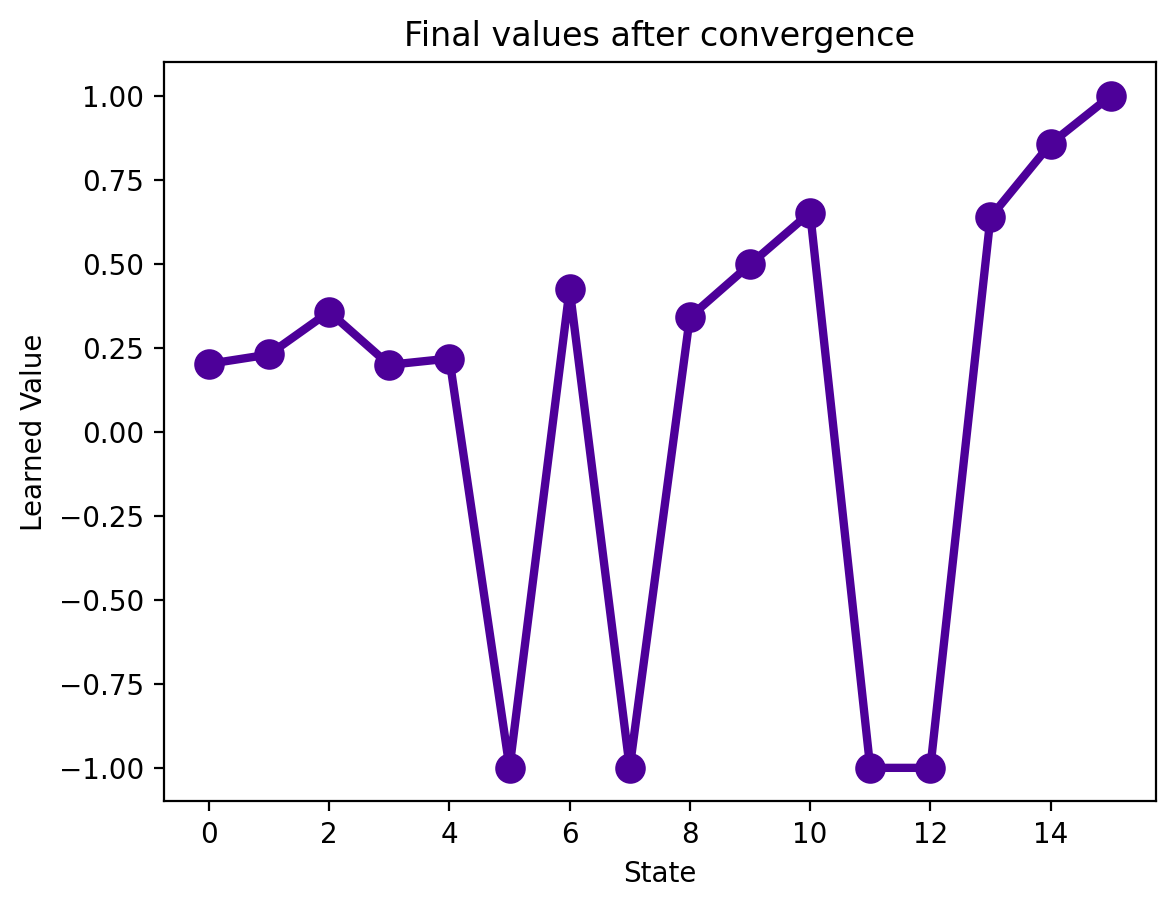

In [9]:
# Hyperparameters
SMALL_ENOUGH = 0.05
GAMMA = 0.9         
NOISE = 0.20

iteration = 0

while True:
    biggest_change = 0
    for s in range(env.observation_space.n):   
        if s in policy:
            
            old_v = V[s]
            new_v = 0
            
            for a in actions[s]:
                # Select next state correpsonding to action a
                if a == 'L': # Left
                    nxt = s - 1 # Next state when moving to the left
                if a == 'D': # Down
                    nxt = s + 4 # Next state when moving down
                if a == 'R': # Right
                    nxt = s + 1 # Next state when moving to the right
                if a == 'U': # Up
                    nxt = s - 4 # Next state when moving up

                # Intended action value (with (1 - NOISE) probability)
                nxt = tuple([nxt])  # Convert to tuple for uniformity
                intended_value = (1 - NOISE) * V[nxt[0]]

                # Now calculate the value for random alternative actions
                possible_moves = [x for x in actions[s]]  # All available actions
                random_value = 0
                if possible_moves:
                    probability_per_alt = NOISE / len(possible_moves)  # Evenly distribute noise

                    for random_a in possible_moves:
                        if random_a == 'L':  # Left
                            act = s - 1 if s % 4 != 0 else s
                        if random_a == 'D':  # Down
                            act = s + 4 if s + 4 < 16 else s
                        if random_a == 'R':  # Right
                            act = s + 1 if (s + 1) % 4 != 0 else s
                        if random_a == 'U':  # Up
                            act = s - 4 if s - 4 >= 0 else s
                        
                        act = tuple([act])
                        random_value += probability_per_alt * V[act[0]]  # Sum up contributions from all alternatives
                # Calculate the total value for the state using the Bellman equation
                v = rewards[s] + GAMMA * (intended_value + random_value)
                if v > new_v: # If this the best action so far, update the policy with this action
                    new_v = v
                    policy[s] = a
  
            # Save the best of all actions for the state                                
            V[s] = new_v
            biggest_change = max(biggest_change, np.abs(old_v - V[s]))   
            
    if iteration % 5000 == 0: 
        print("Episode {}, Biggest change = {}".format(iteration, biggest_change))

    # Stop learning if max difference in v value between two iteration is smaller than predefined threshold          
    if biggest_change < SMALL_ENOUGH:
        print("State values converged in {} iteratons.".format(iteration))
        # Let's look at the learned values
        plt.plot(range(0, 16), list(V.values()), 'o-', color = [0.3, 0, 0.6], linewidth=3, markersize = 10)
        plt.xlabel('State')
        plt.ylabel('Learned Value');
        plt.title('Final values after convergence')
        break
    iteration += 1
plt.show()

### Exploit the state values found by the value iteration algorithm

In [10]:
# List of rewards
rewards = []

# Play 10 games
for episode in range(10):
    
    # Reset the environment
    state,p = env.reset()  
                           
    done = False
    total_rewards = 0
    
    while not done:
        
        env.render()  # Use Gym to vizualize a nice-looking environment
        
        # Follow the learned policy for current state except from time to time (NOISE) 
        be_greedy = np.random.random() > NOISE
        if be_greedy:
            a = policy[state]
        else:
            a = np.random.choice([i for i in actions[state]])
        # Map our custom definition of L,D,R,U to Gym's action space code: 0,1,2,3
        if a == 'L': # Left
            action = 0
        if a == 'D': # Down
            action = 1
        if a == 'R': # Right
            action = 2
        if a == 'U': # Up
            action = 3           

        # Take the action and observe the resulting state and reward 
        new_state, reward, done, info, p = env.step(action)

        # Track rewards
        total_rewards = total_rewards + reward
        
        # Our new state is state
        state = new_state
 
    episode += 1
    # rewards.append(total_rewards)
    
env.close() # Comment to fix error "display Surface quit", this will let the env opened 

KeyboardInterrupt: 

### [Optional Exercice: ] 
Train the agent for a more challenging problem by increasing the amount of randomness, and/or changing the slippery feature to `True`, and/or increasing the size of the FrozenLake grid. Feel free to experiment with any learning strategy and custom rules/models that make sense to you. Starting next week, we will implement more general, model-free RL algorithms.

## Thank you everyone!